# Load Datasets

In [29]:
import numpy as np
import pandas as pd
import os

import sklearn.tree
import sklearn.ensemble

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

In [30]:
# Clone repository in order to get access locally to the datasets
!rm -rf .git README.md
!git clone -b playing-emsembled-methods https://github.com/sergio-gimenez/anomaly-4G-detection 

fatal: destination path 'anomaly-4G-detection' already exists and is not an empty directory.


In [31]:
!ls -la

total 20
drwxr-xr-x 1 root root 4096 Dec 31 17:57 .
drwxr-xr-x 1 root root 4096 Dec 31 17:44 ..
drwxr-xr-x 3 root root 4096 Dec 31 17:57 anomaly-4G-detection
drwxr-xr-x 1 root root 4096 Dec 21 17:29 .config
drwxr-xr-x 1 root root 4096 Dec 21 17:29 sample_data


In [32]:
train = pd.read_csv('anomaly-4G-detection/ML-MATT-CompetitionQT2021_train.csv', sep=';')
test = pd.read_csv('anomaly-4G-detection/ML-MATT-CompetitionQT2021_test.xls', sep=';' )

In [33]:
# Separate labels from data 
X = train.drop('Unusual', axis='columns')#.to_numpy()
y = train['Unusual']#.to_numpy()

# We split the data into training and validation subsets (80% and 20%) in
# order to validate our training
X_train, X_validation, y_train, y_validation = train_test_split(X, y, 
                                                                train_size=0.8,
                                                                random_state=1, stratify = y)
X_test = test

In [34]:
#Refactor time feature to minuts and cellName to unique identifier 1:1
def getTimeInMinutes(x):
  hh, mm  = x.split(":")
  return int(hh)* 60 + int(mm)

def createCellNameDictionary(data):
  cellList = []
  for i in data["CellName"]:
    cellList.append(i)
  cellList = set(cellList)
  cellDict = {}
  for idx, value in enumerate(cellList):
    cellDict[value]=idx
  return cellDict

def refactorFeaturesDataframe(data):
  data["Time"] = data["Time"].apply(lambda x: getTimeInMinutes(x))
  cellNameDict = createCellNameDictionary(data);
  data["CellName"] = data["CellName"].apply(lambda x: cellNameDict[x])
  return data


In [35]:
#Refactoring data from features to useful values
X_train = refactorFeaturesDataframe(X_train).to_numpy()
y_plot = y_train
y_train = y_train.to_numpy()

X_validation = refactorFeaturesDataframe(X_validation).to_numpy()
y_validation = y_validation.to_numpy()

X_test = refactorFeaturesDataframe(test).to_numpy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Pre-processing

In [103]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

colors=['green' if l==0 else 'red' for l in y_train]

## PCA n = 3 component 

In [104]:
pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()
X_norm = scaler.fit_transform(X_train)
X_reduce = pca.fit_transform(X_norm)

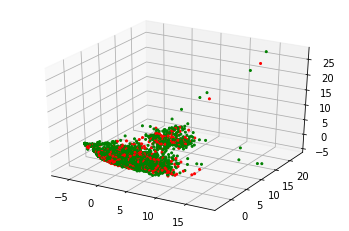

In [105]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_reduce[:,0], X_reduce[:, 1], X_reduce[:, 2], s=4, alpha=1,color=colors)
plt.show()

## PCA n = 2 component

In [106]:
pca = PCA(n_components=3)  # Reduce to k=2 dimensions
scaler = StandardScaler()
X_norm = scaler.fit_transform(X_train)
X_reduce = pca.fit_transform(X_norm)

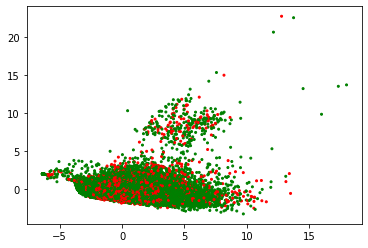

In [107]:
fig, ax = plt.subplots()
ax.scatter(X_reduce[:,0], X_reduce[:, 1], s=4,color=colors)
plt.show()

In [ ]:
import seaborn as sns
sns.lmplot('Time', 'Amount', dataset, hue='Class', fit_reg=False)
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()

# Submission Formatting

In [ ]:
%%shell
# Create submission file if it does not exists
file=predictions.csv
if [ ! -e "$file" ] ; then
    touch anomaly-4G-detection/"$file"
fi

In [ ]:
# Create index column in data frame object
submission_dataframe = pd.DataFrame(np.arange(1, 9159), columns=['Id']) 

# Append predictions of test data as column
submission_dataframe['Label'] = pred_test

# Convert Data Frame object to CSV
submission_dataframe.to_csv('predictions.csv', index=False)

!mv predictions.csv anomaly-4G-detection/
predictions = pd.read_csv('anomaly-4G-detection/predictions.csv')
predictions

In [ ]:
#!rm anomaly-4G-detection/predictions.csv

In [ ]:
clf_GS.best_params_